# Bank Marketing Analysis

by Casey Durfee <casey.durfee@colorado.edu>

I took a look at the "Bank Marketing" dataset in the  UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

The data covers a bank's outbound marketing efforts to over 40,000 customers, with some information about the customers and the state of the economy at the time they were contacted, and whether they bought the product (a term deposit account) or not.

My goal will be to build a Machine Learning model to predict who is likely to buy. Such a model could help the bank spend its sales and marketing budget more effectively, or be used to predict the success of using telemarketing to promote new products.

This data was used in the following research papter:

```[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014```

That paper is available online here: https://www.sciencedirect.com/science/article/pii/S016792361400061X#t0010

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## file obtained from https://archive.ics.uci.edu/ml/machine-learning-databases/00222/

bank_data = pd.read_csv("bank-additional-full.csv", delimiter=";")

bank_data.sample()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
37874,40,technician,married,high.school,no,yes,no,cellular,aug,mon,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.821,5076.2,no


## Initial Data Exploration & Cleaning

It's always good to start by checking whether any of the columns have null values. They don't.

In [26]:
for col in bank_data.columns:
    if bank_data[col].isnull().any():
        print(f"Nulls in {bank_data[col]}")

### Categorical Variables

Next, let's check the categorical variables, such as `job`, `marital`, `education`, `default`, `housing`, `loan`, and `contact`:

In [27]:
for col in bank_data.columns:
    if bank_data[col].dtype == 'object':
        print(bank_data[col].value_counts())
        print("\n")

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


no         32588
unknown     8597
yes            3
Name: default, dtype: int64


yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


cellular     26144
telephone    15044
Name: contact, dtype: int64


may    13769
jul     717

#### Unknown Values in Categorical Variables

Many of the categorical variables have 'unknown' values: `job`, `marital`, `education`, `default`, `housing`, `loan`. (for reference, `default` is whether the customer is in default on any loans. `housing` is whether the customer has a housing loan. `loan` is whether the customer has a non-housing loan.)

While unknown values are not ideal, I don't believe it makes sense to throw out these values. If we find that customers with `unknown` values are less likely to buy the product, that tells us something too: that the business should stop trying to market to customers that they don't have enough demographic information about. In other words, `unknown` conveys less information than the other categorical values, but not zero information.

#### Are the Categorical Variables Reasonable?

`poutcome` is whether previous marketing campaigns to this person were successful. It looks like this is a very strong predictor of whether this campaign will be successful:

In [38]:
bank_data.poutcome.value_counts()

success_and_yes = len(bank_data[ (bank_data.poutcome == 'success') & (bank_data.y == 'yes')])
success_and_no = len(bank_data[ (bank_data.poutcome == 'success') & (bank_data.y == 'no')])


print(f"success rate for customers who have been previously " + \
      f"marketed to successfully: {100 * success_and_yes / (success_and_yes + success_and_no)} %%")

success rate for customers who have been previously marketed to successfully: 65.1128914785142 %%


#### Date fields

`month` and `day_of_week` indicate when the customer was contacted.

Note that for `month` and `day_of_week` it doesn't make sense to convert them to numbers. 'February' isn't January +1 within the context of this model (there's no reason to believe that jan < feb < mar < ... as far as conversion rate). so we should treat them as categorical variables even though they do have a 'natural' numerical equivalent.

Because this data is over an irregular span of time, the days of the week are evenly distributed, but the months are not. Over a third of the calls are from the month of May. I believe this strongly limits the value of this info.

0.3342963970088375

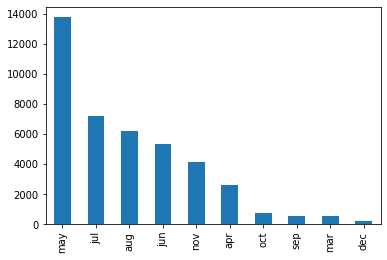

In [44]:
bank_data['month'].value_counts().plot.bar()

len(bank_data[bank_data.month == 'may']) / len(bank_data)

#### `y` and class imbalance

`y` is whether the sales attempt was successful or not. Converting `y` is easy:

In [ ]:
bank_data['y'] = bank_data['y'].replace({'no': 0, 'yes': 1})

About 90% of sales calls are unsuccessful. That's a pretty big class imbalance, which means we need to be careful with how we select and score our model, because a model that always predicts `no`, regardless of the feature data, would be accurate 89% of the time:

In [7]:
print(100 * sum(bank_data.y == "no") / len(bank_data.y))

88.73458288821988


sklearn's `DummyClassifier` always predicts the majority class, so can be used as a baseline comparison to keep us honest when comparing models.

#### Converting Categoricals to Dummy Variables

If a categorical variable has `n` possible values, only `n-1` dummy variables are needed to encode the information, since the last category can be inferred from the value of the other categories.

So I am converting each categorical variable to dummy variables, then dropping the least frequent dummy variable. `get_dummies` has an option to drop the first dummy variable, but I think dropping the least frequent makes the model marginally more understandable, because on most of these variables, "unknown" is the least frequent option.

In [23]:
for field in bank_data.columns:
    if bank_data[field].dtype == 'object':
        dummies = pd.get_dummies(bank_data[field], prefix=field)
        toss_variable = f"{field}_{bank_data[field].value_counts().idxmin()}"

        bank_data = pd.concat([bank_data, dummies], axis='columns') \
                        .drop([field, toss_variable], axis='columns')

### Numerical values

Now, let's look at the rest of the non-categorical values. We mostly get numerical data about previous contacts with the customer, and about the economy at the time of contact. The original paper analyzed more demographic data, such as the customer's net worth, but here we are only given age. The range and distribution look reasonable:

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


<AxesSubplot:>

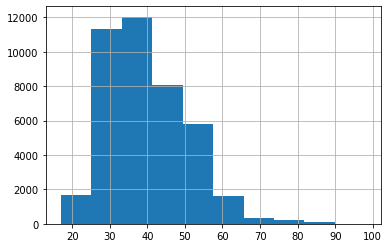

In [24]:
print(bank_data.age.describe())

bank_data.age.hist()

#### Previous Contacts Data

We are given several fields about previous contacts with the customer.

`pdays` is the number of days since last contact, and if there hasn't been a previous contact, the value 999 is assigned. It looks like this is the most common value in the column, indicating most people haven't been contacted before.

The column `previous` indicates the number of previous contacts with the customer. This column should always be 0 if `pdays` is 999. Let's make sure that's true.

In [8]:
possibly_bad_pdays = bank_data[(bank_data.pdays == 999) & (bank_data.previous > 0) ]

print("possibly bad 'pday' values: %.2f %%" % (100 * len(possibly_bad_pdays.previous) / len(bank_data)))

possibly bad 'pday' values: 9.98 %


Oh no! Almost 10% of the rows have a nonsensical value for this column. So it's not really valuable.

The documentation cautions that the  `duration` column is not a realistic column to use for a predicative model, so I am going to drop it as well:

> this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

However, examining the original paper, they used this field in their analysis, and unsurprisingly, it was one of the strongest predictors they found! On top of that, 4 of the top 5 strongest predictors they found were not included in the public dataset, presumably for privacy or proprietary reasons. So we won't be able to compare our models to theirs, because we don't have the same data they did, and are trying to make predictions rather than post-hoc explanations.

In [9]:
bank_data = bank_data.drop(['pdays', 'duration'], axis=1)

`campaign` is the "number of contacts performed during this campaign and for this client (numeric, includes last contact)". It has an extremely long tail, which is unusual:

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64


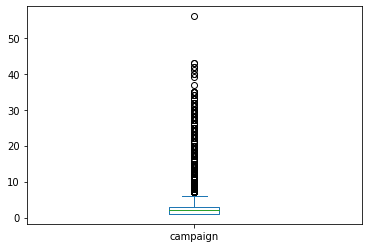

In [10]:
bank_data.campaign.plot.box()

print(bank_data.campaign.describe())

The largest value is 56 times. That seems like a huge number of contacts to one person. Does the distribution of this data make sense?

Intuitively, it seems like `campaign` should follow an exponential distribution. We can use a qq plot to verify this. Does this field act like a prototypical exponential distribution?

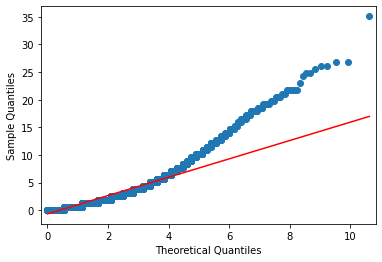

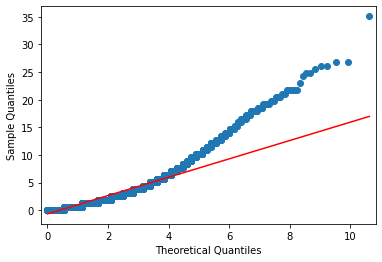

In [11]:
sm.qqplot(bank_data.campaign, fit=True, line='r', dist=stats.expon)

Ideally, we'd like to see a flat line there. So it doesn't (based on the eye test, at least) appear to be an exponential distribution, but it's close.  The `gamma` distribution fits better, since it's just a more generalized version of the exponential.

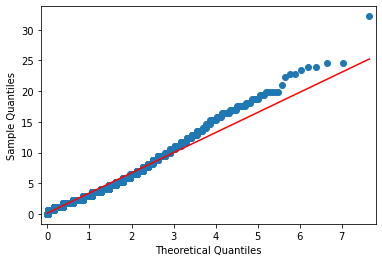

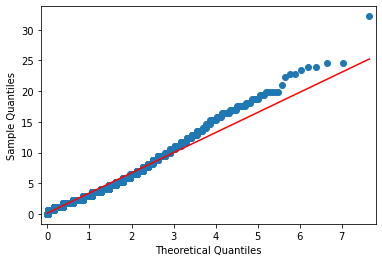

In [45]:
sm.qqplot(bank_data.campaign, fit=True, line='r',dist=stats.gamma)

This looks like a pretty good fit, so for now I'm going to assume that the data in the `campaign` field is organic, rather than being due to some type of error. I think it would be justified to remove the one extreme outlier (in the top right of the chart above) because it clearly diverges from the other 41,000 data points. But it's also unlikely to have a major impact given the number of samples.

The percentile values may end up being a better predictor than the raw values due to the long tail, so let's add that in:

In [13]:
### TODO: did I ever actually use this field for anything?

## bank_data['campaign_quartile'] = pd.qcut(bank_data['campaign'], 4, labels=False, duplicates='drop')

### Economic Factors Data

The remaining variables are all macroeconomic statistics at the time the customer was contacted: `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m` and `nr.employed`.

We need to check correlations between them. Although we've been given 5 metrics here, are we really getting 5 unique dimensions of data, or can we eliminate some?

In [14]:
macro_predictors = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                    'euribor3m', 'nr.employed']

bank_data.loc[:, macro_predictors].corr()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,0.906970,0.522034,0.100513,0.945154,1.000000


We can see `emp.var.rate`, `euribor3m` and `nr.employed` are very highly correlated. This is a bit surprising since `euribor3m` is the European inter-bank lending rate, `emp.var.rate` is the employment rate, and `nr.employed` is the number of employees. 

The strong correlation between lending rate and employment rate is curious, but may be explained by the time that this data came from, which was May 2008 to November 2010. That was around the period ofthe global economic crisis at the end of 2008, which makes me question how valuable this economic data is for predictions in the future.

Since the correlations are so high, I am only going to use the `euribor3m` rate.

Most of these categorical variables don't have a natural order to them, so we should encode them as dummy variables. For example, for the `marriage` field, instead of arbitrarily assigning integer values to `{single, married, divorced, unknown}`, we're adding variables like `{is_single, is_married, is_divorced, is_unknown}` that will be 1 or 0.

### Train-test split

Now we can split the data into train and test:

In [15]:
y = bank_data['y'].copy()
x = bank_data.copy().drop(['y'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


## First Model: Random Forest


A random forest classifier seems like a good first option, since it doesn't require normalization.

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(x_train, y_train)

print(f"Random Forest accuracy: {rf_model.score(x_train, y_train)}")


Random Forest accuracy: 0.9946585735963581


The random forest classifier looks pretty good. 99.4% accurate on the training set. However, it's not significantly better than a dummy classifier on the test set as far as accuracy. This illustrates how accuracy isn't the right metric to use when the classes are imbalanced. 

In [62]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy_model = DummyClassifier().fit(x_train, y_train)
dummy_pred = dummy_model.predict(x_test)

rf_pred = rf_model.predict(x_test)

print(f"Random Forest Model accuracy: {rf_model.score(x_test, y_test)}")
#print(classification_report(y_test, rf_pred))


print(f"Dummy Model accuracy: {dummy_model.score(x_test, y_test)}")
#print(classification_report(y_test, dummy_pred))



Random Forest Model accuracy: 0.8929351784413693
Dummy Model accuracy: 0.8865015780529255


#### ROC AUC - Why?

ROC is looking at the ratio of true positive rate to false positive rate. The formula for true positive rate is $\frac{TP}{TP + FN}$. Since the dummy classifier always says yes FN=1 so TPR = 1. False positive rate is $\frac{FP}{FP + TN}$. TN is 0, so FPR = 1 as well. So the AUC will always be .5 for the dummy classifier -- it's the triangle defined by $\{(0,0), (1,1), (1,0)\}$.

Any model that's better at producing true positives than false positives will have an AUC over .5, with the perfect classifier having an AUC of 1.

So instead of accuracy, for the rest of this notebook, we are going to use the AUC of the ROC curve, which is a much better measure of how relatively good two models are. (This was also the approach of the authors of the original paper.)

Let's calculate the ROC AUC for Random Forest:

In [63]:
fpr, tpr, _ = roc_curve(y_test, rf_pred)
roc_auc = roc_auc_score(y_test, rf_pred)

print(roc_auc)

0.6304607073058395


## Second Model: Gradient Boosting

Gradient Boosting is fast and often performs extremely well, without the need for scaling.

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()

gb_model.fit(x_train, y_train)


GradientBoostingClassifier()

In [61]:
gb_pred = gb_model.predict(x_test)

print(f"Gradient Boosting ROC AUC: {roc_auc_score(y_test, gb_pred)}")

Gradient Boosting ROC AUC: 0.6073477239227012


Without any tweaking of params, we get a worse ROC AUC than random forest. The best I was able to get was around .62, worse than the untuned random forest. So perhaps gradient boosting is a bad match for this problem.


## Third Model: SVM
For SVM, we want to keep the training data as small as possible because training time can be prohibitive. Because we have an imbalance of 'yes' and 'no' responses, if we're just training on a sample of the data, we want to make sure it includes as many of the rarer 'yes' responses as possible.

sklearn's SVC class does have a scaling option that's supposed to help with class imbalances (`class_weight='balanced'`), but it's extremely slow to train on all 40,000 points in this data set. I found to get decent training times, I needed to restrict to around 20% of the data rather than the 80% that `train_test_split` produced.

I was curious if creating a set of data that contains all the 'yes' responses, then an even amount of 'no' responses that were randomly picked would do better than the `class_weight=balanced` option.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

all_yes = bank_data[bank_data.y == 1]
matching_nos = bank_data.sample(n=len(all_yes)) ## todo: need to ensure these are NOT IN x_test!

data_svm = pd.concat([all_yes, matching_nos], axis='rows')

y = data_svm['y'].copy()
x = data_svm.copy().drop(['y'], axis=1)

x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(x_train_svm)
x_train_svm = scaler.transform(x_train_svm)


Note we are training the SVM on a special set of data that has an equal number of yes and no datapoints. However, we are then evaluating it against the same `x_test` sample as the other models.

In [21]:
x_test_scaled = scaler.transform(x_test)

svc_model = SVC().fit(x_train_svm, y_train_svm)
svc_pred = svc_model.predict(x_test_scaled)
print(f"even inputs ROC score: {roc_auc_score(y_test, svc_pred)}")


even inputs model score: 0.7743384316581695
even inputs ROC score: 0.740762238945097


In [47]:
x_train_balanced = scaler.transform(x_train)
svc_model_class_weight = SVC(class_weight='balanced').fit(x_train_balanced, y_train)
svc_class_weight_pred = svc_model_class_weight.predict(x_test_scaled)

print(f"balanced param model ROC score: {roc_auc_score(y_test, svc_class_weight_pred)}")

balanced param model score: 0.8474144209759651
balanced param model ROC score: 0.7344161545215102


So it appears that the 'even inputs' training did a slightly better job (based on ROC) than the 'balanced' training did (for a training set of the same size.)

## Evaluating the Models

Let's look at the AUC of the ROC curve to see which of these models has performed the best.

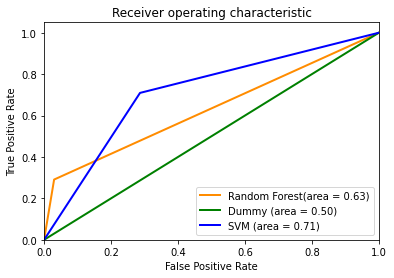

In [58]:
## Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_pred)
roc_auc = roc_auc_score(y_test, rf_pred)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Random Forest(area = %0.2f)" % roc_auc,
)

### Plot dummy -- AUC should be .5
fpr, tpr, _ = roc_curve(y_test, dummy_pred)

roc_auc = roc_auc_score(y_test, dummy_pred)
plt.plot(
    fpr,
    tpr,
    color="green",
    lw=lw,
    label="Dummy (area = %0.2f)" % roc_auc,
)

### Plot for SVC
fpr, tpr, _ = roc_curve(y_test_svm, svc_class_weight_pred)

roc_auc = roc_auc_score(y_test_svm, svc_class_weight_pred)
plt.plot(
    fpr,
    tpr,
    color="blue",
    lw=lw,
    label="SVC (area = %0.2f)" % roc_auc,
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()